In [3]:
from builtins import sorted
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
import os
import sys
import shutil
import pandas as pd
from tabulate import tabulate
import mir_eval

from scipy import signal, ndimage
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec
import IPython.display as ipd

from scipy.signal import argrelmax
import textwrap
from midi2audio import FluidSynth

import madmom
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.spectrogram import (
            FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor,
            SpectrogramDifferenceProcessor)
from madmom.processors import ParallelProcessor, Processor, SequentialProcessor
from madmom.features.downbeats import DBNDownBeatTrackingProcessor, RNNDownBeatProcessor, RNNBarProcessor, DBNBarTrackingProcessor
from madmom.evaluation.beats import BeatEvaluation

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# use a custom sound font
FluidSynth('default_sound_font.sf2')

# use a custom sample rate
FluidSynth(sample_rate=22050)

import warnings
warnings.filterwarnings("ignore")

In [4]:
genres_list = ["ChaCha", "Jive", "Quickstep", "Rumba", "Samba", "Tango", "Viennese waltz", "Waltz"]
tempogram_list = ["fourier", "autocorrelation"]

In [5]:
album_list = ["Abba", "Alan_Parsons_Project", "Alirio Diaz", "aphex_twin", "Asian_Dub_Foundation", "Autechre",
              "Aviador_Dro", "Bach", "Bach - Walcha", "Bebel_Gilberto", "Bela_Bartok", "Bernstein_conducts_Stravinsky",
              "Billie Holiday CD1", "Bjork", "Cabaret_Voltaire", "Carlinhos_Brown", "charles_mingus", "Classic",
              "Elton Medeiros, Nelson Sargento & Galo Preto", "Fado", "Femi_Kuti", "Genesis", "greek", "GUITARE+",
              "john_coltrane", "John Frusciante", "Jose' Merce'", "Kocani Orkester", "Manu_Chao", "more greek",
              "Nina Pastori", "Olivier Chassain", "Papakonstantinou", "Paulinho da Viola & Elton Medeiros", "Santana",
              "Songs", "Teresa Cristina", "Tomatito", "Vangelis", "Xatzidakis"]

In [6]:
def sort_key_num(name_file:str, str_key=str.lower, nzero:int=5) -> str:
    return str_key( re.sub("(.[0-9]+)",lambda x: x.group(0).zfill(nzero),name_file) )

In [7]:
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

In [8]:
def madmom_feature(wav):
    sig = SignalProcessor(num_channels=1, sample_rate=44100 )
    multi = ParallelProcessor([])
    frame_sizes = [1024, 2048, 4096]
    num_bands = [3, 6, 12]
    for frame_size, num_bands in zip(frame_sizes, num_bands):
        frames = FramedSignalProcessor(frame_size=frame_size, fps=100)
        stft = ShortTimeFourierTransformProcessor()  # caching FFT window
        filt = FilteredSpectrogramProcessor(
            num_bands=num_bands, fmin=30, fmax=17000, norm_filters=True)
        spec = LogarithmicSpectrogramProcessor(mul=1, add=1)
        diff = SpectrogramDifferenceProcessor(
            diff_ratio=0.5, positive_diffs=True, stack_diffs=np.hstack)
        # process each frame size with spec and diff sequentially
        multi.append(SequentialProcessor((frames, stft, filt, spec, diff)))
    # stack the features and processes everything sequentially
    pre_processor = SequentialProcessor((sig, multi, np.hstack))
    feature = pre_processor.process(wav)
    return feature

In [9]:
def get_beat_tracking_ballroom(visualization):
    # path = "./HW2 Datasets/Ballroom/"
    wav_path = "./HW2 Datasets/Ballroom/BallroomData/"
    ground_truth_path = "./HW2 Datasets/Ballroom/BallroomAnnotations-master/"
    f_score_dict = {}
    for genre in genres_list:
        f_score_dict[genre] = {}
        for root, dirs, files in os.walk(os.path.join(wav_path, genre)):
            files = sorted(files, key=sort_key_num)
            # print(files)
            song_no = 0
            for name in files:
                if name.endswith((".wav")):
                    f_score_dict[genre][song_no] = {}
                    # tempo, beat_times = librosa.beat.beat_track(x, sr=sr, start_bpm=60, units='time')
                    audio_file_path = wav_path + genre + "/" + name
                    # print("audio_file_path: ", audio_file_path)
                    bpm_name = name.replace(".wav", ".beats")

                    sr = 22050
                    audio, sr = librosa.load(audio_file_path, sr = sr)
                    
                    tempo, beat_times = librosa.beat.beat_track(y = audio, sr = sr)#  start_bpm = 60, units = 'time'
                    estimate_beats = librosa.frames_to_time(beat_times, sr = sr)
                    
                    # proc = DBNDownBeatTrackingProcessor(beats_per_bar=[1, 2, 3, 4, 5, 6, 7], fps=100)
                    #act = RNNDownBeatProcessor()(audio_file_path)
                    
                    proc = DBNBarTrackingProcessor(beats_per_bar=[1, 2, 3, 4, 5, 6, 7])
                    act = RNNBarProcessor()((audio_file_path, estimate_beats))
                    estimate_result = proc(act)
                    print("estimate_result:", estimate_result)
                    
                    # # print(tempo)
                    # # print(beat_times)
                    
                    # if visualization == 1:
                    #     plt.figure(figsize=(14, 5))
                    #     librosa.display.waveshow(audio, alpha=0.6)
                    #     plt.vlines(beat_times, -1, 1, color='r')
                    #     plt.ylim(-1, 1)
                    #     plt.show()
                        
                    #     beat_times_diff = np.diff(beat_times)
                    #     plt.figure(figsize=(14, 5))
                    #     plt.hist(beat_times_diff, bins=50, range=(0,4))
                    #     plt.xlabel('Beat Length (seconds)')
                    #     plt.ylabel('Count')
                    #     plt.show()

                    ground_truth_beats, beat_per_frame = mir_eval.io.load_labeled_events(os.path.join(ground_truth_path, bpm_name))
                    print("beat_per_frame:", beat_per_frame)
                    scr = BeatEvaluation(estimate_result, ground_truth_beats)
                    print(scr.fmeasure,scr.pscore,scr.cemgil,scr.cmlc,scr.cmlt,
                                        scr.amlc,scr.amlt)
                    #print(ground_truth_beats)
                    # ground_truth_beats = mir_eval.beat.trim_beats(ground_truth_beats)
                    # #located within a tolerance of ±70 ms around the ground truth annotation, 70ms = 0.007sec
                    # # f_score = mir_eval.beat.f_measure(ground_truth_beats, beat_times, f_measure_threshold = 0.07)
                    # f_score = mir_eval.beat.f_measure(ground_truth_beats, estimate_beats, f_measure_threshold = 0.07)
                    
                    # # print('f_score:', f_score)
                    # f_score_dict[genre][song_no]["f_score"] = f_score
                    # song_no += 1
    return f_score_dict

In [10]:
def get_beat_tracking_JCS():
    wav_path = "./HW2 Datasets/JCS_dataset/audio/"
    ground_truth_path = "./HW2 Datasets/JCS_dataset/annotations/"
    f_score_dict = {}
    # print(wav_path)
    
    gt_files = []
    for root, dirs, files in os.walk(os.path.join(ground_truth_path)):
        gt_files = sorted(files, key=sort_key_num)
        # print(gt_files)
    for root, dirs, files in os.walk(os.path.join(wav_path)):
        files = sorted(files, key=sort_key_num)
        # print(files)
        song_no = 0
        for name in files:
            if name.endswith((".mp3")):
                f_score_dict[song_no] = {}
                # tempo, beat_times = librosa.beat.beat_track(x, sr=sr, start_bpm=60, units='time')
                audio_file_path = wav_path + name
                # print("audio_file_path: ", audio_file_path)
                bpm_name =  [s for s in gt_files if any(xs in s for xs in name)]#name.replace(".wav", ".txt")
                print(bpm_name)
                bpm_name = bpm_name[song_no]

                sr = 22050
                audio, sr = librosa.load(audio_file_path, sr = sr)

                tempo, beat_times = librosa.beat.beat_track(y = audio, sr = sr)#  start_bpm = 60, units = 'time'
                estimate_beats = librosa.frames_to_time(beat_times, sr = sr)

                # proc = DBNDownBeatTrackingProcessor(beats_per_bar=[1, 2, 3, 4, 5, 6, 7], fps=100)
                #act = RNNDownBeatProcessor()(audio_file_path)
                
                proc = DBNBarTrackingProcessor(beats_per_bar=[3, 4])
                act = RNNBarProcessor()((audio_file_path, estimate_beats))
                estimate_result = proc(act)
                #print("estimate_result:", estimate_result[:,1])
                meter_prediction = estimate_result[:,1]
                print("meter_prediction: ", meter_prediction)
                
                ground_truth_beats, beat_per_frame = mir_eval.io.load_labeled_events(os.path.join(ground_truth_path, bpm_name))                
                meter_ground_truth = [float(item) for item in beat_per_frame]
                print("len(ground_truth_beats): ", len(ground_truth_beats))
                print("beat_per_frame: ", meter_ground_truth)

                count_correct = 0
                print("Len meter_prediction:", len(meter_prediction))
                print("Len meter_ground_truth:", len(meter_ground_truth))
                length_list = [len(meter_prediction), len(meter_ground_truth)]
                min_of_seqlen = np.min(length_list)
                #print("min_of_seqlen: ", min_of_seqlen)
                for i in range(min_of_seqlen):
                    if meter_prediction[i] == meter_ground_truth[i]:
                        count_correct += 1
                
                acc_result = count_correct/min_of_seqlen
                #print("Acc: ", acc_result)
                
                # scr = BeatEvaluation(estimate_result[:,1], list_of_beat_per_frame)
                # print(scr.fmeasure,scr.pscore,scr.cemgil,scr.cmlc,scr.cmlt,
                #                     scr.amlc,scr.amlt)
                # frame-wise accuracy
                f_score_dict[song_no]["Acc"] = acc_result
                song_no += 1
    return f_score_dict

In [11]:
jcs_meter_dict = get_beat_tracking_JCS()
jcs_meter_dict

['001_beats.txt', '002_beats.txt', '003_beats.txt', '004_beats.txt', '005_beats.txt', '006_beats.txt', '007_beats.txt', '008_beats.txt', '009_beats.txt', '010_beats.txt', '011_beats.txt', '012_beats.txt', '013_beats.txt', '014_beats.txt', '015_beats.txt', '016_beats.txt', '017_beats.txt', '018_beats.txt', '019_beats.txt', '020_beats.txt', '021_beats.txt', '022_beats.txt', '023_beats.txt']
meter_prediction:  [2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3

{0: {'Acc': 0.49653579676674364},
 1: {'Acc': 0.810546875},
 2: {'Acc': 0.012711864406779662},
 3: {'Acc': 0.20666666666666667},
 4: {'Acc': 0.14722222222222223},
 5: {'Acc': 0.03463203463203463},
 6: {'Acc': 0.0},
 7: {'Acc': 0.4796747967479675},
 8: {'Acc': 0.0},
 9: {'Acc': 0.15767634854771784},
 10: {'Acc': 0.0},
 11: {'Acc': 0.1652542372881356},
 12: {'Acc': 0.20309810671256454},
 13: {'Acc': 0.02608695652173913},
 14: {'Acc': 0.35537190082644626},
 15: {'Acc': 0.7286821705426356},
 16: {'Acc': 0.05714285714285714},
 17: {'Acc': 0.21476510067114093},
 18: {'Acc': 0.0},
 19: {'Acc': 0.13829787234042554},
 20: {'Acc': 0.1774193548387097},
 21: {'Acc': 0.0},
 22: {'Acc': 0.0603448275862069}}

In [12]:
columns = ['song_no', 'Acc']
jcs_score_dict_df = pd.DataFrame.from_dict({(i): jcs_meter_dict[i]
                            for i in jcs_meter_dict.keys()
                            }, orient='columns').T

jcs_score_dict_df.reset_index(inplace=True)
jcs_score_dict_df.columns = ['song_no', 'Acc']
print(jcs_score_dict_df)
result_jcs_song_no = jcs_score_dict_df.groupby(['song_no']).mean()

    song_no       Acc
0         0  0.496536
1         1  0.810547
2         2  0.012712
3         3  0.206667
4         4  0.147222
5         5  0.034632
6         6  0.000000
7         7  0.479675
8         8  0.000000
9         9  0.157676
10       10  0.000000
11       11  0.165254
12       12  0.203098
13       13  0.026087
14       14  0.355372
15       15  0.728682
16       16  0.057143
17       17  0.214765
18       18  0.000000
19       19  0.138298
20       20  0.177419
21       21  0.000000
22       22  0.060345


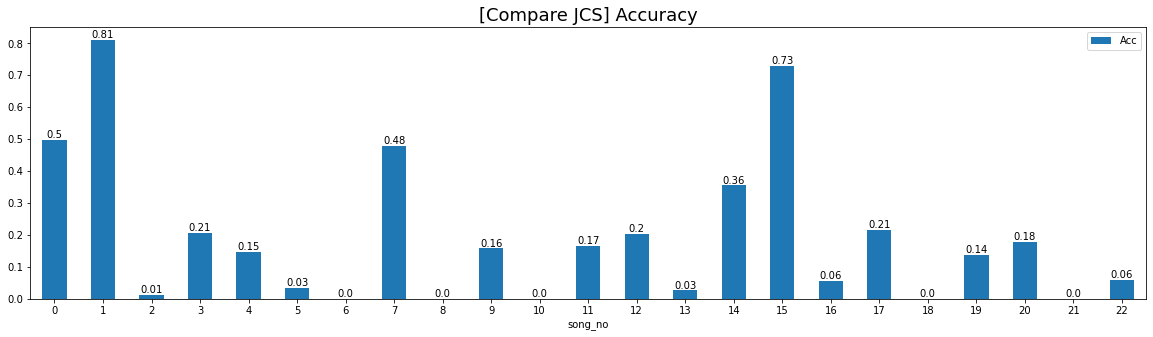

In [13]:
ax = result_jcs_song_no.plot(kind='bar', figsize=(20, 5), rot=0)
ax.set_title("[Compare JCS] Accuracy", fontsize=18)
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', )

In [14]:
def get_beat_tracking_JCS():
    wav_path = "./HW2 Datasets/JCS_dataset/audio/"
    ground_truth_path = "./HW2 Datasets/JCS_dataset/annotations/"
    f_score_dict = {}
    # print(wav_path)
    
    gt_files = []
    for root, dirs, files in os.walk(os.path.join(ground_truth_path)):
        gt_files = sorted(files, key=sort_key_num)
        # print(gt_files)
    for root, dirs, files in os.walk(os.path.join(wav_path)):
        files = sorted(files, key=sort_key_num)
        # print(files)
        song_no = 0
        for name in files:
            if name.endswith((".mp3")):
                f_score_dict[song_no] = {}
                # tempo, beat_times = librosa.beat.beat_track(x, sr=sr, start_bpm=60, units='time')
                audio_file_path = wav_path + name
                # print("audio_file_path: ", audio_file_path)
                bpm_name =  [s for s in gt_files if any(xs in s for xs in name)]#name.replace(".wav", ".txt")
                print(bpm_name)
                bpm_name = bpm_name[song_no]

                sr = 22050
                audio, sr = librosa.load(audio_file_path, sr = sr)

                tempo, beat_times = librosa.beat.beat_track(y = audio, sr = sr)#  start_bpm = 60, units = 'time'
                estimate_beats = librosa.frames_to_time(beat_times, sr = sr)

                # proc = DBNDownBeatTrackingProcessor(beats_per_bar=[1, 2, 3, 4, 5, 6, 7], fps=100)
                #act = RNNDownBeatProcessor()(audio_file_path)
                
                proc = DBNBarTrackingProcessor(beats_per_bar=[3, 4])
                act = RNNBarProcessor()((audio_file_path, estimate_beats))
                estimate_result = proc(act)
                #print("estimate_result:", estimate_result[:,1])
                meter_prediction = estimate_result[:,1]
                print("meter_prediction: ", meter_prediction)
                
                ground_truth_beats, beat_per_frame = mir_eval.io.load_labeled_events(os.path.join(ground_truth_path, bpm_name))                
                meter_ground_truth = [float(item) for item in beat_per_frame]
                print("len(ground_truth_beats): ", len(ground_truth_beats))
                print("beat_per_frame: ", meter_ground_truth)

                count_correct = 0
                print("Len meter_prediction:", len(meter_prediction))
                print("Len meter_ground_truth:", len(meter_ground_truth))
                length_list = [len(meter_prediction), len(meter_ground_truth)]

                distance, path = fastdtw(meter_prediction, meter_ground_truth, dist=euclidean)
                print(distance)
                print(path)

                min_of_seqlen = np.min(length_list)
                for i in range(min_of_seqlen):
                    if meter_prediction[i] == meter_ground_truth[i]:
                        count_correct += 1
                
                acc_result = count_correct/min_of_seqlen

                f_score_dict[song_no]["Acc"] = acc_result
                f_score_dict[song_no]["distance"] = distance
                song_no += 1
    return f_score_dict

In [16]:
jcs_meter_dict = get_beat_tracking_JCS()
jcs_meter_dict

['001_beats.txt', '002_beats.txt', '003_beats.txt', '004_beats.txt', '005_beats.txt', '006_beats.txt', '007_beats.txt', '008_beats.txt', '009_beats.txt', '010_beats.txt', '011_beats.txt', '012_beats.txt', '013_beats.txt', '014_beats.txt', '015_beats.txt', '016_beats.txt', '017_beats.txt', '018_beats.txt', '019_beats.txt', '020_beats.txt', '021_beats.txt', '022_beats.txt', '023_beats.txt']
meter_prediction:  [2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1. 2. 3. 1.
 2. 3

{0: {'Acc': 0.49653579676674364, 'distance': 295.0},
 1: {'Acc': 0.810546875, 'distance': 164.0},
 2: {'Acc': 0.012711864406779662, 'distance': 16.0},
 3: {'Acc': 0.20666666666666667, 'distance': 283.0},
 4: {'Acc': 0.14722222222222223, 'distance': 179.0},
 5: {'Acc': 0.03463203463203463, 'distance': 6.0},
 6: {'Acc': 0.0, 'distance': 6.0},
 7: {'Acc': 0.4796747967479675, 'distance': 163.0},
 8: {'Acc': 0.0, 'distance': 168.0},
 9: {'Acc': 0.15767634854771784, 'distance': 1316.0},
 10: {'Acc': 0.0, 'distance': 316.0},
 11: {'Acc': 0.1652542372881356, 'distance': 598.0},
 12: {'Acc': 0.20309810671256454, 'distance': 575.0},
 13: {'Acc': 0.02608695652173913, 'distance': 566.0},
 14: {'Acc': 0.35537190082644626, 'distance': 372.0},
 15: {'Acc': 0.7286821705426356, 'distance': 35.0},
 16: {'Acc': 0.05714285714285714, 'distance': 36.0},
 17: {'Acc': 0.21476510067114093, 'distance': 264.0},
 18: {'Acc': 0.0, 'distance': 6.0},
 19: {'Acc': 0.13829787234042554, 'distance': 173.0},
 20: {'Acc':

    song_no       Acc  distance
0         0  0.496536     295.0
1         1  0.810547     164.0
2         2  0.012712      16.0
3         3  0.206667     283.0
4         4  0.147222     179.0
5         5  0.034632       6.0
6         6  0.000000       6.0
7         7  0.479675     163.0
8         8  0.000000     168.0
9         9  0.157676    1316.0
10       10  0.000000     316.0
11       11  0.165254     598.0
12       12  0.203098     575.0
13       13  0.026087     566.0
14       14  0.355372     372.0
15       15  0.728682      35.0
16       16  0.057143      36.0
17       17  0.214765     264.0
18       18  0.000000       6.0
19       19  0.138298     173.0
20       20  0.177419     891.0
21       21  0.000000      33.0
22       22  0.060345     149.0


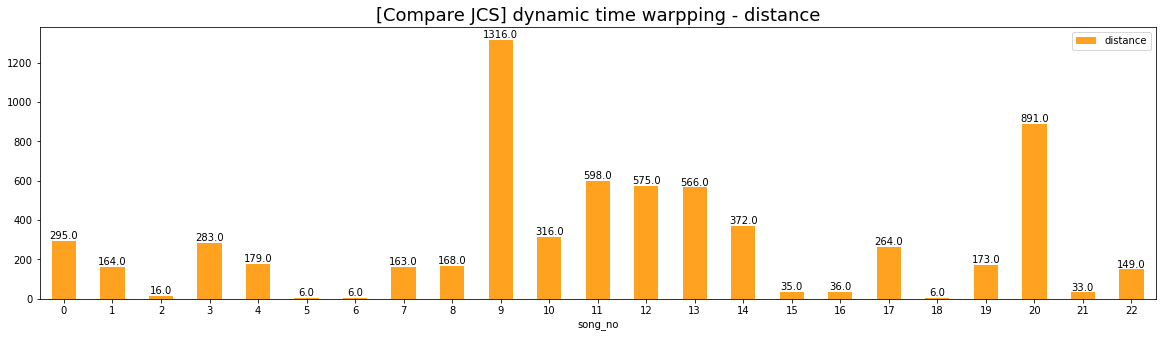

In [20]:
columns = ['song_no', 'Acc', 'distance']
jcs_score_dict_df = pd.DataFrame.from_dict({(i): jcs_meter_dict[i]
                            for i in jcs_meter_dict.keys()
                            }, orient='columns').T

jcs_score_dict_df.reset_index(inplace=True)
jcs_score_dict_df.columns = ['song_no', 'Acc', 'distance']
print(jcs_score_dict_df)
result_jcs_song_no = jcs_score_dict_df.drop(columns=['Acc']).groupby(['song_no']).mean()
ax = result_jcs_song_no.plot(kind='bar', figsize=(20, 5), rot=0, color="#ffa21f")
ax.set_title("[Compare JCS] dynamic time warpping - distance", fontsize=18)
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', )